<a href="https://colab.research.google.com/github/camilecampos/mpes25-1-gp-avancado/blob/main/GP_Avan%C3%A7ado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Codigo para a analise de risco

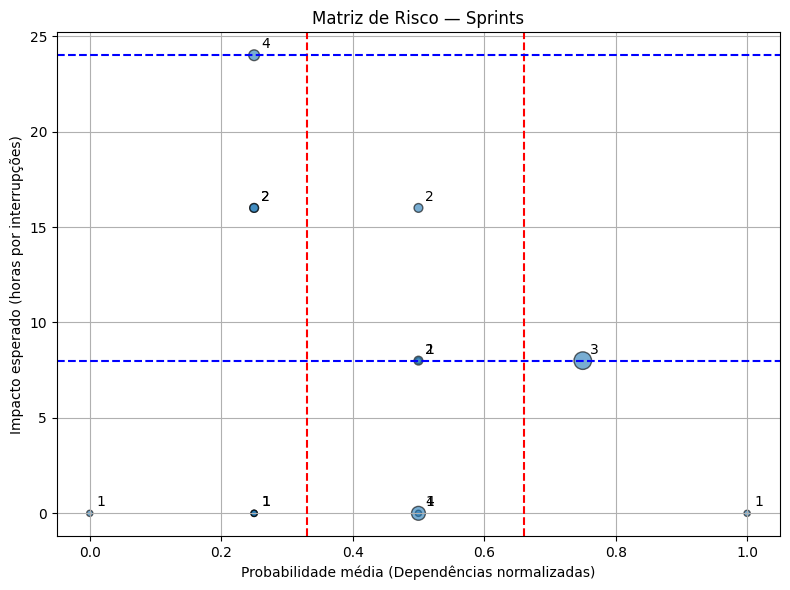

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminho do arquivo
file_path = "analise (2).xlsx"

# Carregar a aba "analise"
df = pd.read_excel(file_path, sheet_name="analise")

# Selecionar colunas relevantes
agg_future = df[["Sprint", "Story Point", "Dependencia", "Interrupcoes"]].copy()

# Probabilidade média = dependências normalizadas (0–1)
agg_future["Prob_Media"] = agg_future["Dependencia"] / agg_future["Dependencia"].max()

# Impacto esperado em horas = interrupções * 8h
agg_future["Impacto_Esperado_h"] = agg_future["Interrupcoes"] * 8

# Tamanho dos pontos = Story Points
agg_future["Histórias"] = agg_future["Story Point"]

# Criar gráfico
plt.figure(figsize=(8,6))
x = agg_future["Prob_Media"].values
y = agg_future["Impacto_Esperado_h"].values
sizes = agg_future["Histórias"].values * 20  # multiplicador para dar destaque

plt.scatter(x, y, s=sizes, alpha=0.6, edgecolors="k")

# Anotar pontos com o número do Sprint
for i, row in agg_future.iterrows():
    plt.annotate(int(row["Sprint"]),
                 (row["Prob_Media"], row["Impacto_Esperado_h"]),
                 textcoords="offset points", xytext=(5,5))

# Linhas de referência (probabilidade 0.33/0.66 e impacto 8/24 horas)
plt.axvline(0.33, linestyle="--", color="red")
plt.axvline(0.66, linestyle="--", color="red")
plt.axhline(8, linestyle="--", color="blue")
plt.axhline(24, linestyle="--", color="blue")

plt.xlabel("Probabilidade média (Dependências normalizadas)")
plt.ylabel("Impacto esperado (horas por interrupções)")
plt.title("Matriz de Risco — Sprints")
plt.grid(True)
plt.tight_layout()
plt.show()


Codigo apenas com a previsão de esforço em horas (regressão).


MAE (horas por história): 8.58
R²: -0.495


,Sprint,Horas Estimadas,Horas Reais,Horas Previstas,Desvio (%),Status
0,1,35.0,41.2,NaN,17.8,CONCLUÍDO
1,2,40.0,40.1,NaN,0.2,CONCLUÍDO
2,3,40.0,45.3,NaN,13.1,CONCLUÍDO
3,4,40.0,49.7,NaN,24.3,CONCLUÍDO
4,5,155.0,NaN,71.7,-53.7,PREVISTO
5,6,110.0,NaN,73.3,-33.3,PREVISTO


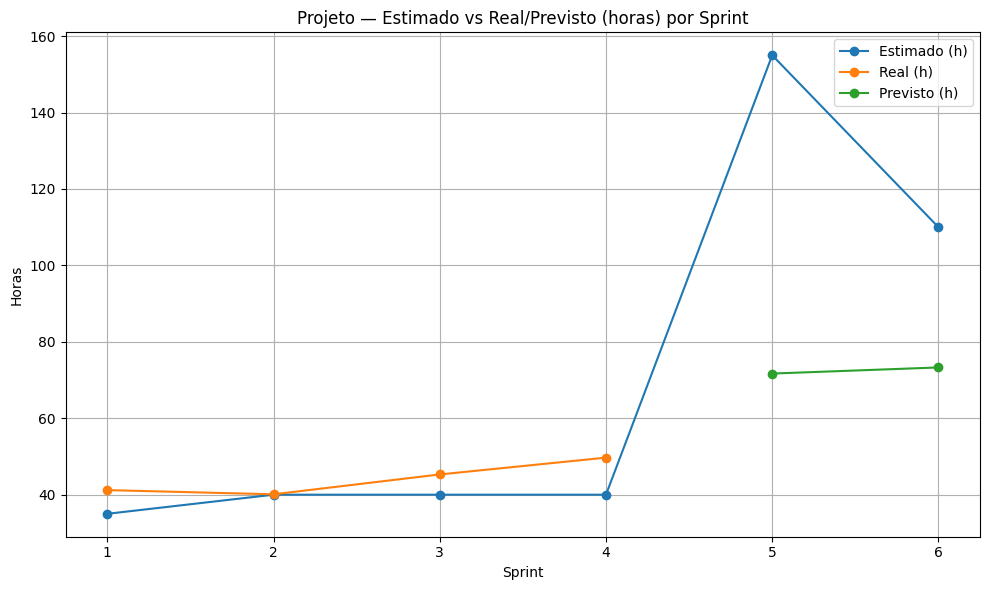

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ===== 1) Carregar dados =====
file_path = "analise (2).xlsx"  # ajuste o caminho no Colab
df = pd.read_excel(file_path, sheet_name="analise")

# ===== 2) Preparar dados =====
np.random.seed(42)

# Horas planejadas = Story Point * 5
df["Horas_Planejadas"] = df["Story Point"] * 5.0

# Ajustar Dependencia e Interrupcoes
df["Dependencia"] = df["Dependencia"].fillna(0).astype(int)
df["Interrupcoes"] = df["Interrupcoes"].fillna(0).astype(int)

# Simular horas reais apenas para concluídas
df["Horas_Reais"] = np.where(
    df["Status"] == "Done",
    df["Horas_Planejadas"] * np.random.normal(1.1, 0.15, size=len(df)),
    np.nan
)

# Separar datasets
df_treino = df[df["Status"] == "Done"].copy()
df_futuro = df[df["Status"] != "Done"].copy()

# ===== 3) Treinar modelo =====
X = df_treino[["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]]
y = df_treino["Horas_Reais"]

preprocess = ColumnTransformer(transformers=[
    ("num", "passthrough", ["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]),
])

model = Pipeline(steps=[("prep", preprocess),
                       ("rf", RandomForestRegressor(n_estimators=300, random_state=42))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE (horas por história): {mae:.2f}")
print(f"R²: {r2:.3f}")

# ===== 4) Prever para as futuras =====
X_future = df_futuro[["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]]
pred_future = model.predict(X_future)
df_futuro["Horas_Previstas"] = np.round(pred_future, 2)

# ===== 5) Agregar por sprint =====
agg_treino = df_treino.groupby("Sprint").agg(
    Estimado_h=("Horas_Planejadas","sum"),
    Real_h=("Horas_Reais","sum")
)

agg_futuro = df_futuro.groupby("Sprint").agg(
    Estimado_h=("Horas_Planejadas","sum"),
    Previsto_h=("Horas_Previstas","sum")
)

rows = []
for s in sorted(df["Sprint"].unique()):
    if s in agg_treino.index:
        est = agg_treino.loc[s, "Estimado_h"]
        real = agg_treino.loc[s, "Real_h"]
        desvio = (real - est) / est * 100.0 if est > 0 else np.nan
        rows.append([s, round(est,1), round(real,1), np.nan, round(desvio,1), "CONCLUÍDO"])
    else:
        est = agg_futuro.loc[s, "Estimado_h"]
        prev = agg_futuro.loc[s, "Previsto_h"]
        desvio = (prev - est) / est * 100.0 if est > 0 else np.nan
        rows.append([s, round(est,1), np.nan, round(prev,1), round(desvio,1), "PREVISTO"])

df_sprints = pd.DataFrame(rows, columns=["Sprint","Horas Estimadas","Horas Reais","Horas Previstas","Desvio (%)","Status"])
display(df_sprints)

# ===== 6) Gráfico =====
plt.figure(figsize=(10,6))
sprints = df_sprints["Sprint"].values
plt.plot(sprints, df_sprints["Horas Estimadas"].values, marker="o", label="Estimado (h)")

mask_real = df_sprints["Status"]=="CONCLUÍDO"
plt.plot(df_sprints.loc[mask_real,"Sprint"], df_sprints.loc[mask_real,"Horas Reais"], marker="o", label="Real (h)")

mask_prev = df_sprints["Status"]=="PREVISTO"
plt.plot(df_sprints.loc[mask_prev,"Sprint"], df_sprints.loc[mask_prev,"Horas Previstas"], marker="o", label="Previsto (h)")

plt.title("Projeto — Estimado vs Real/Previsto (horas) por Sprint")
plt.xlabel("Sprint")
plt.ylabel("Horas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

📊 Regressão -> MAE: 8.58 | R²: -0.495
📊 Classificação Spillover -> F1: 1.000


,Sprint,Horas Estimadas,Horas Reais,Horas Previstas,Desvio (%),Status
0,1,35.0,41.2,NaN,17.8,CONCLUÍDO
1,2,40.0,40.1,NaN,0.2,CONCLUÍDO
2,3,40.0,45.3,NaN,13.1,CONCLUÍDO
3,4,40.0,49.7,NaN,24.3,CONCLUÍDO
4,5,155.0,NaN,71.7,-53.7,PREVISTO
5,6,110.0,NaN,73.3,-33.3,PREVISTO


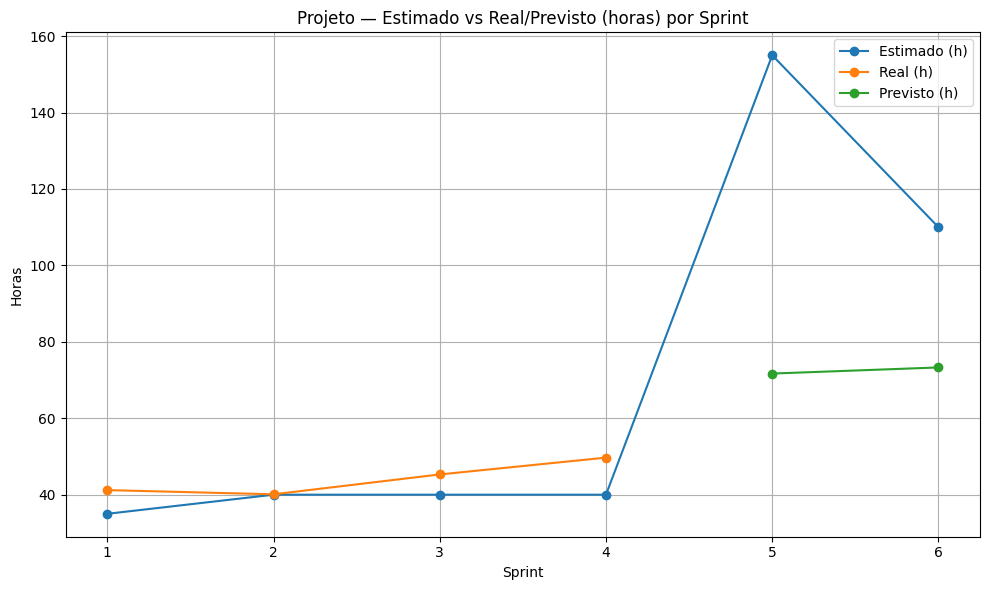

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ===== 1) Carregar dados =====
file_path = "analise (2).xlsx"  # ajuste o caminho
df = pd.read_excel(file_path, sheet_name="analise")

# ===== 2) Preparar dados =====
np.random.seed(42)

# Corrigir nome se necessário
df.rename(columns=lambda x: x.strip(), inplace=True)
if "Interrrupcoes" in df.columns:
    df.rename(columns={"Interrrupcoes": "Interrupcoes"}, inplace=True)

# Horas planejadas = Story Point * 5
df["Horas_Planejadas"] = df["Story Point"] * 5.0

# Ajustar Dependencia e Interrupcoes
df["Dependencia"] = df["Dependencia"].fillna(0).astype(int)
df["Interrupcoes"] = df["Interrupcoes"].fillna(0).astype(int)

# Simular horas reais apenas para concluídas
df["Horas_Reais"] = np.where(
    df["Status"] == "Done",
    df["Horas_Planejadas"] * np.random.normal(1.1, 0.15, size=len(df)),
    np.nan
)

# Criar coluna de spillover (1 se estourou)
df["Spillover"] = np.where(
    (df["Status"] == "Done") & (df["Horas_Reais"] > df["Horas_Planejadas"]),
    1, 0
)

# Separar datasets
df_treino = df[df["Status"] == "Done"].copy()
df_futuro = df[df["Status"] != "Done"].copy()

# ===== 3) Modelo de regressão =====
X_reg = df_treino[["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]]
y_reg = df_treino["Horas_Reais"]

model_reg = Pipeline(steps=[
    ("prep", ColumnTransformer([("num", "passthrough", X_reg.columns)])),
    ("rf", RandomForestRegressor(n_estimators=300, random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)
model_reg.fit(X_train, y_train)
y_pred_reg = model_reg.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_reg)
r2 = r2_score(y_test, y_pred_reg)

print(f"📊 Regressão -> MAE: {mae:.2f} | R²: {r2:.3f}")

# ===== 4) Modelo de classificação (spillover) =====
X_clf = df_treino[["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]]
y_clf = df_treino["Spillover"]

model_clf = Pipeline(steps=[
    ("prep", ColumnTransformer([("num", "passthrough", X_clf.columns)])),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
])

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, test_size=0.25, random_state=42)
model_clf.fit(X_train_c, y_train_c)
y_pred_clf = model_clf.predict(X_test_c)

f1 = f1_score(y_test_c, y_pred_clf)
print(f"📊 Classificação Spillover -> F1: {f1:.3f}")

# ===== 5) Prever para sprints futuras =====
# Regressão para horas
X_future_reg = df_futuro[["Horas_Planejadas", "Story Point", "Dependencia", "Interrupcoes"]]
df_futuro["Horas_Previstas"] = np.round(model_reg.predict(X_future_reg), 2)

# Classificação para spillover
df_futuro["Spillover_Previsto"] = model_clf.predict(X_future_reg)

# ===== 6) Agregar por sprint =====
agg_treino = df_treino.groupby("Sprint").agg(
    Estimado_h=("Horas_Planejadas","sum"),
    Real_h=("Horas_Reais","sum")
)

agg_futuro = df_futuro.groupby("Sprint").agg(
    Estimado_h=("Horas_Planejadas","sum"),
    Previsto_h=("Horas_Previstas","sum")
)

rows = []
for s in sorted(df["Sprint"].unique()):
    if s in agg_treino.index:
        est = agg_treino.loc[s, "Estimado_h"]
        real = agg_treino.loc[s, "Real_h"]
        desvio = (real - est) / est * 100.0 if est > 0 else np.nan
        rows.append([s, round(est,1), round(real,1), np.nan, round(desvio,1), "CONCLUÍDO"])
    else:
        est = agg_futuro.loc[s, "Estimado_h"]
        prev = agg_futuro.loc[s, "Previsto_h"]
        desvio = (prev - est) / est * 100.0 if est > 0 else np.nan
        rows.append([s, round(est,1), np.nan, round(prev,1), round(desvio,1), "PREVISTO"])

df_sprints = pd.DataFrame(rows, columns=["Sprint","Horas Estimadas","Horas Reais","Horas Previstas","Desvio (%)","Status"])
display(df_sprints)

# ===== 7) Gráfico =====
plt.figure(figsize=(10,6))
sprints = df_sprints["Sprint"].values
plt.plot(sprints, df_sprints["Horas Estimadas"].values, marker="o", label="Estimado (h)")

mask_real = df_sprints["Status"]=="CONCLUÍDO"
plt.plot(df_sprints.loc[mask_real,"Sprint"], df_sprints.loc[mask_real,"Horas Reais"], marker="o", label="Real (h)")

mask_prev = df_sprints["Status"]=="PREVISTO"
plt.plot(df_sprints.loc[mask_prev,"Sprint"], df_sprints.loc[mask_prev,"Horas Previstas"], marker="o", label="Previsto (h)")

plt.title("Projeto — Estimado vs Real/Previsto (horas) por Sprint")
plt.xlabel("Sprint")
plt.ylabel("Horas")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
